#### 필요 패키지
- folium
- lxml
- geopandas 및 의존성 패키지들(https://thlee33.medium.com/windows-10%EC%97%90%EC%84%9C-geopandas-%EC%84%A4%EC%B9%98%ED%95%98%EA%B8%B0-2021-07-f07efea9294a)

---

In [4]:
import folium

location = [37.2410864, 127.1775537]

def getNewMap():
  return folium.Map(location = location, tiles='openstreetmap', zoom_start=11)

### 행정동 지도

In [5]:
# geojson 형식의 파일을 dataframe으로 만들고 'adm_nm' 컬럼에 문자열 '용인시'를 포함하는 행만 추출

import geopandas as gpd

df = gpd.read_file('../data/dataset/행정동.geojson', encoding ='utf-8')
df = df[df['adm_nm'].str.contains('용인시')]
df.head()

,OBJECTID,adm_nm,adm_cd,adm_cd2,sgg,sido,sidonm,sggnm,adm_cd8,geometry
1464,1484,경기도 용인시처인구 포곡읍,3119111,4146125000,41461,41,경기도,용인시처인구,31191110,"MULTIPOLYGON (((127.27860 37.30544, 127.28042 ..."
1465,1485,경기도 용인시처인구 모현읍,3119112,4146125300,41461,41,경기도,용인시처인구,31191120,"MULTIPOLYGON (((127.28334 37.34531, 127.28316 ..."
1466,1486,경기도 용인시처인구 남사읍,3119114,4146125900,41461,41,경기도,용인시처인구,31191140,"MULTIPOLYGON (((127.18870 37.08636, 127.18623 ..."
1467,1487,경기도 용인시처인구 이동읍,3119113,4146125600,41461,41,경기도,용인시처인구,31191130,"MULTIPOLYGON (((127.17441 37.22459, 127.17541 ..."
1468,1488,경기도 용인시처인구 원삼면,3119134,4146134000,41461,41,경기도,용인시처인구,31191340,"MULTIPOLYGON (((127.34840 37.20436, 127.34731 ..."


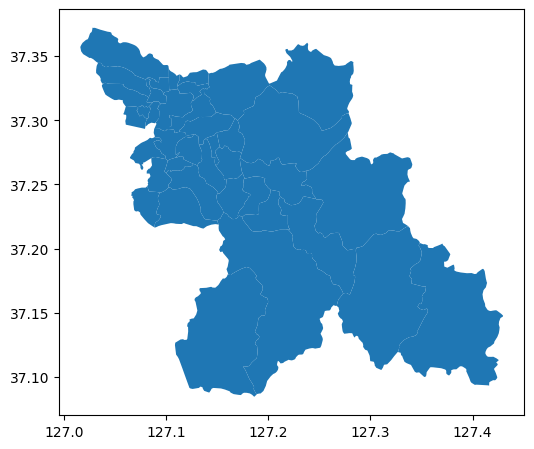

In [6]:
import matplotlib.pyplot as plt

df.plot(figsize=(6, 6))
plt.show()

### 전기 충전소 지도

In [7]:
station_map = getNewMap()

for _, r in df.iterrows():
  simplifed_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance = 0.001)
  geo = simplifed_geo.to_json()
  geo = folium.GeoJson(data = geo, style_function= lambda x: {'fillColor' : 'orange'})
  folium.Popup(r['adm_nm']).add_to(geo)
  geo.add_to(station_map)
  
station_map

In [8]:
import pandas as pd
station_df = pd.read_xml('../data/dataset/전기충전소정보.xml', encoding='UTF-8')

In [9]:
addr_series = station_df['addr'].str.contains('용인시', na=False)
addr_series.isna().sum()
yongin_station_df = station_df[addr_series]

In [10]:
yongin_station_df.shape[0]

4453

In [11]:
positions = yongin_station_df[['lat', 'lng']].values.tolist()

In [12]:
for position in positions:
  folium.Marker(location = position).add_to(station_map)

station_map


In [13]:
station_map.save('../map/station.html')

In [14]:
# 인구 데이터 시각화. 보류
# population_df = pd.read_csv('../data/dataset/읍면동별_세대_및_인구_등록인구__20221006220338.csv', encoding ='utf-8')

### 수요 지도

In [15]:
import pandas as pd

resident_df = pd.read_csv('../data/dataset/1.ev_app_resident.csv')
activity_df = pd.read_csv('../data/dataset/2.ev_app_activity.csv')

In [16]:
# TODO 행정동 geo data에 합쳐서 지도에 수요 나타내기 -> Chropleth 맵 그리기
resident_df = resident_df[['adng_nm','cell_id', 'cell_xcrd', 'cell_ycrd', 'count_cust']]
resident_df.head()

,adng_nm,cell_id,cell_xcrd,cell_ycrd,count_cust
0,동백1동,86135034,127.15225,37.286300,3.522
1,상현2동,84375196,127.09008,37.309536,4.231
2,포곡읍,87958893,127.21660,37.274303,18.440
3,신봉동,84119243,127.08097,37.323480,4.335
4,상현2동,84423187,127.09178,37.306840,4.231


In [17]:
# 지역명으로 그룹화 후 수요를 합해 새로운 데이터프레임 생성

resident_demand_df = resident_df.groupby('adng_nm')['count_cust'].sum().to_frame().reset_index()
activity_demand_df = activity_df.groupby('adng_nm')['count_cust'].sum().to_frame().reset_index()

resident_demand_df.head()

,adng_nm,count_cust
0,구갈동,76362.452
1,구성동,70444.529
2,기흥동,26243.494
3,남사읍,32876.348
4,동백1동,58443.210


In [18]:
demand_df = pd.merge(resident_demand_df, activity_demand_df, on='adng_nm')
demand_df['count_cust'] = demand_df['count_cust_x'] + demand_df['count_cust_y']

In [19]:
# 수요 데이터와 매핑하기 위해서 지리 데이터의 지역명 중 읍, 동만 남김

anm_nm = df['adm_nm'].apply(lambda x : x.split()[2])
df['adm_nm'] = anm_nm

In [20]:
df.head()

,OBJECTID,adm_nm,adm_cd,adm_cd2,sgg,sido,sidonm,sggnm,adm_cd8,geometry
1464,1484,포곡읍,3119111,4146125000,41461,41,경기도,용인시처인구,31191110,"MULTIPOLYGON (((127.27860 37.30544, 127.28042 ..."
1465,1485,모현읍,3119112,4146125300,41461,41,경기도,용인시처인구,31191120,"MULTIPOLYGON (((127.28334 37.34531, 127.28316 ..."
1466,1486,남사읍,3119114,4146125900,41461,41,경기도,용인시처인구,31191140,"MULTIPOLYGON (((127.18870 37.08636, 127.18623 ..."
1467,1487,이동읍,3119113,4146125600,41461,41,경기도,용인시처인구,31191130,"MULTIPOLYGON (((127.17441 37.22459, 127.17541 ..."
1468,1488,원삼면,3119134,4146134000,41461,41,경기도,용인시처인구,31191340,"MULTIPOLYGON (((127.34840 37.20436, 127.34731 ..."


In [21]:
# 검은 색으로 나타나는 구역은 수요 정보가 없는 곳으로 추정

demand_map = getNewMap()

folium.Choropleth(
    geo_data = df,
    data = resident_demand_df,
    columns = ('adng_nm', 'count_cust'),
    key_on = "feature.properties.adm_nm",
    fill_color = "OrRd",
    legend_name = "지역별 수요",
).add_to(demand_map)

demand_map

In [22]:
demand_map.save('../map/demand.html')